In this notebook, I inspect the data provided by TfL and prepare it for subsequent analysis.

I focus only on the demand at London Underground (LU) stations within the operating hours of the LU network. I then check the amount of data in each of the months to determine which months are suitable for further studies. I also plot the typical demand profile for each day of the week.

Lastly, I generate the time series data of entries, exits and throughput for individual stations.

# Staging

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import seaborn as sns
import warnings

In [2]:
sns.set(style="darkgrid")

# Underground Stations

## List of stations and codes from TfL crowding data website

In [3]:
# Annual station count data retrieved from http://crowding.data.tfl.gov.uk/
# Accessed on 19 May 2022
# Use this to get the list of LU stations
df_lu_stn = pd.read_excel('data/AC2021_ByQhrEntryExit.xlsx',
                          sheet_name='ByQhr', skiprows=6)

In [4]:
# Get only LU stations
df_lu_stn = df_lu_stn[df_lu_stn['Mode'] == 'LU']

In [5]:
# Check number of stations and station names
list_lu_stn = sorted(list(set(df_lu_stn['Station'])))
print(f'Number of stations: {len(list_lu_stn)}')
#list_lu_stn

Number of stations: 270


There are a total of 268 Underground stations on the dataset (duplicates - Edgware Road and Hammersmith - counted only once). 

According to TfL website (https://tfl.gov.uk/corporate/about-tfl/what-we-do; accessed on 19 May 2022), there are 272 stations altogether. I could not find an authoritative source for the full list, but Wikipedia had such a list (https://en.wikipedia.org/wiki/List_of_London_Underground_stations; accessed on 19 May 2022). Based on Wikipedia's list, the following stations are counted as two separate stations but counted as one station in the dataset.
- Bank and Monument
- Edgware Road
- Hammersmith
- Paddington

This explains the difference in the number of stations.

In [6]:
# Get station codes
list_lu_code = [df_lu_stn[df_lu_stn['Station'] == stn]['NLC'].iloc[0] for stn in list_lu_stn]

## List of stations and codes from data provided by TfL

In [7]:
# Dictionary of list for data period
data_period = {'2020': ['January', 'February', 'March',
                        'April', 'May', 'June', 
                        'July', 'August', 'September',
                        'October', 'November', 'December'],
               '2021': ['January', 'February', 'March',
                        'April', 'May', 'June',
                        'July', 'August', 'September',
                        'October']}

In [8]:
# Create lists to hold stations
list_stn = []
list_code = []

In [9]:
# Concatenate all TfL datasets together
for yr, mths in data_period.items():
    for mth in mths:

        # Read file
        mth_yr = mth+yr
        filepath = 'data/tfl_data/'+mth_yr+'_Compiled.csv'
        print(f'Checking {mth_yr}')
        df_temp = pd.read_csv(filepath, 
                              usecols=['CalendarDate', 'EntryTime',
                                       'EntryStationName', 'EntryLocationId',
                                       'ExitStationName', 'ExitLocationId',
                                       'NumberOfJourneys'])

        # Concatenate
        if mth_yr == data_period[list(data_period.keys())[0]][0] + list(data_period.keys())[0]:
            df_combined = df_temp.copy()
        else:
            df_combined = pd.concat([df_combined, df_temp], ignore_index=True)

        # Get lists of station names and code from TfL dataset
        for stn_type in ['Entry', 'Exit']:
            name_col = stn_type+'StationName'
            code_col = stn_type+'LocationId'
            # Find new stations that are not already in list,
            # and get their names and codes
            temp_stn = list(set(df_temp[~df_temp[name_col].isin(list_stn)][name_col]))
            temp_code = [df_temp[df_temp[name_col] == temp][code_col].iloc[0] for temp in temp_stn]
            # Append to lists
            list_stn = list_stn+temp_stn
            list_code = list_code+temp_code

print('Done!')

Checking January2020
Checking February2020
Checking March2020
Checking April2020
Checking May2020
Checking June2020
Checking July2020
Checking August2020
Checking September2020
Checking October2020
Checking November2020
Checking December2020
Checking January2021
Checking February2021
Checking March2021
Checking April2021
Checking May2021
Checking June2021
Checking July2021
Checking August2021
Checking September2021
Checking October2021
Done!


In [10]:
print(f'Total number of stations in dataset provided by TfL: {len(set(list_stn))}')

Total number of stations in dataset provided by TfL: 416


In [11]:
#set(list_stn)

## Combine lists of stations and codes from both datasets

In [12]:
# List of duplicate LU stations on TfL dataset
list_tfl_dup = ['Canary Wharf LU', 'Canary Wharf LU (E1)', 'Canary Wharf LU (E2)', 
                'Edgware Road B', 'Edgware Road C&H', 
                'Hammersmith C&H', 'Hammersmith D&P', 
                'Kings Cross LU (North)', 'Kings Cross LU (Tube)', 'Kings Cross LU (Western)',
                'Victoria LU', 'Victoria LU (District)',
                'Waterloo LU (Bloo/Nthn/W&C)', 'Waterloo LU (Colonnade)', 'Waterloo LU (Jubilee)', 
                'Waterloo LU (Main)']

In [13]:
# Create list of duplicate stations added to list of stations from crowding dataset
list_dup = []

In [14]:
# Add duplicate stations (name and code) to the lists from crowding dataset
for stn_name in list_tfl_dup:
    # if their code is not already in list
    stn_code = list_code[list_stn.index(stn_name)]
    if stn_code not in list_lu_code:
        # Add station name and code to lists
        list_lu_stn.append(stn_name)
        list_lu_code.append(stn_code)
        list_dup.append(stn_name)

In [15]:
# Check stations again
#set(list_lu_stn)

In [16]:
# Create mapping for duplicate stations
dup_map = {"Canary Wharf LU": "Canary Wharf LU",
           "Canary Wharf LU (E2)": "Canary Wharf LU",
           "Edgware Road (Bak)": "Edgware Road",
           "Edgware Road (DIS)": "Edgware Road",
           "Hammersmith (DIS)": "Hammersmith",
           "Hammersmith (H&C)": "Hammersmith",
           "King's Cross St. Pancras": "King's Cross St. Pancras",
           "Kings Cross LU (North)": "King's Cross St. Pancras",
           "Kings Cross LU (Western)": "King's Cross St. Pancras",
           "Victoria LU": "Victoria LU",
           "Victoria LU (District)":"Victoria LU",
           "Waterloo LU": "Waterloo LU",
           "Waterloo LU (Colonnade)": "Waterloo LU"}

In [17]:
# Rename duplicate stations
for old_name, new_name in dup_map.items():
    list_lu_stn[list_lu_stn.index(old_name)] = new_name

In [18]:
# Create mapper for stations codes and names
code_name_map = dict(zip(list_lu_code, list_lu_stn))

In [19]:
# Keep only records originating and ending on LU in TfL dataset
df_combined_temp = df_combined[(df_combined['EntryLocationId'].isin(list_lu_code)) & \
                               (df_combined['ExitLocationId'].isin(list_lu_code))]

# Map name of stations
for ent_ex in ['Entry', 'Exit']:
    df_combined_temp[ent_ex+'StationName'] = df_combined_temp[ent_ex+'LocationId'].map(code_name_map)

# Get lists of unique stations
stn_temp = set(list(df_combined_temp['EntryStationName']) + list(df_combined_temp['ExitStationName']))

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [20]:
# Check number of unique stations - there are only 263 stations. 
# Compared to 268 on the crowding data set.
len(stn_temp)

263

In [21]:
# Get list of stations in crowding data but not in TfL data
list_stn_temp = list(set(list_lu_stn)-stn_temp)

In [22]:
# Get station codes and append
for stn_name in list_stn_temp:
    # get station codes
    stn_code = df_combined[df_combined['EntryStationName'] == stn_name]['EntryLocationId'].iloc[0]
    # append
    list_lu_stn.append(stn_name)
    list_lu_code.append(stn_code)

In [23]:
# Create dataframe from code and station name
df_stn = pd.DataFrame(list(zip(list_lu_code, list_lu_stn)), columns=['stn_code', 'stn_name'])
df_stn.sort_values('stn_name', inplace=True)
df_stn.reset_index(drop=True, inplace=True)

# Create mapper for stations codes and names
code_name_map = {row['stn_code']: row['stn_name'] for index, row in df_stn.iterrows()}

In [24]:
# Sanity check
print(f'Number of records: {len(df_stn)}')
print(f'Number of unique stations: {len(set(df_stn["stn_name"]))}')

Number of records: 280
Number of unique stations: 268


In [25]:
# Save dataframe for mapping
#df_stn.to_csv('outputs/stn_data/others/stn_code_name.csv', index=False)

## Update dataset

Here, I drop journeys that do not originate or end on LU. I also drop journeys that start and end at the same station.

In [26]:
# Keep only records originating or ending on LU
df_combined = df_combined[(df_combined['EntryLocationId'].isin(df_stn['stn_code'])) | \
                          (df_combined['ExitLocationId'].isin(df_stn['stn_code']))]

In [27]:
# Number of journeys before dropping
num_journeys_before = sum(df_combined['NumberOfJourneys'])

# Drop records
df_combined =\
    df_combined[df_combined['EntryStationName'] !=
                df_combined['ExitStationName']]

In [28]:
# Number of journeys after dropping
num_journeys_after = sum(df_combined['NumberOfJourneys'])

# Number of journeys dropped
print(f'Total number of journeys before dropping: {num_journeys_before}')
print(f'Total number of journeys after dropping: {num_journeys_after}')
print(f'Number of journeys dropped: {num_journeys_before-num_journeys_after}')

Total number of journeys before dropping: 173389201
Total number of journeys after dropping: 173386248
Number of journeys dropped: 2953


Only 0.002% of journeys started and ended at the same stations. These were dropped from the dataset.

In [29]:
# Map name of stations
for ent_ex in ['Entry', 'Exit']:
    df_combined[ent_ex+'StationName'] = df_combined[ent_ex+'LocationId'].map(code_name_map)

# Rename stations that are not LU
df_combined.fillna(value='Non-LU', inplace=True)

# Operating Hours

## Check operating hours

In [30]:
# Create column with start of entry timeslot
df_combined['EntryTime_Start'] = df_combined['EntryTime'].str[:5]

# Get start time
EntryTime_list = sorted(list(set(df_combined['EntryTime_Start'])))
#EntryTime_list

There were entries throughout the whole day, including at odd hours (e.g. 02:00, 03:00). These may be accidental tap-ins, systems testing, or intermediate validation tap. We can ignore them because there are also likely not many records (to be verified later). We can check the figures on the data from TfL's website to determine the range of hours to use.

In [31]:
# Create dictionary to hold timeslots and number of entries/exits
timeslot_entex = {}

In [32]:
# For all time slot
for col in df_lu_stn.columns[15:]:
    # get the number of entries and exits
    timeslot_entex[col] = sum(df_lu_stn[col])

In [33]:
#timeslot_entex

From TfL's crowding data, we can see that there were no entries between 02:00 and 04:30. Hence, I will set the operating hour of a day to be from 04:30 to 02:00 (start time of timeslot is at 01:45) the next day. I will also change the calendar date in data provided by TfL to operating date, where an operating date is from 04:30 on Day D to 02:00 on Day D+1. These hours are fairly similar to the timings of the first and last trains on LU.

## Set up mapper for operating hours

In [34]:
# Create lists of 15-min interval for entire day
today = pd.to_datetime('today').date()
entrytime_start = list(pd.date_range(today, today+timedelta(days=1), freq='15T').strftime('%H:%M'))

# Keep intervals from 04:30 (18th interval) to 01:45 (7th interval)
entrytime_start = entrytime_start[18:-1] + entrytime_start[:8]

In [35]:
# Create dataframe
df_time = pd.DataFrame(list(zip(entrytime_start,list(range(1,len(entrytime_start)+1)))),
                       columns=['entrytime_start','timeslot'])

# Add column on whether there is a need to add one day to calendar date to make it operating date
shift_cutoff=78
df_time['shift_date'] = [0]*shift_cutoff + [1]*(len(df_time)-shift_cutoff)

In [36]:
# Save dataframe for mapping
#df_time.to_csv('outputs/stn_data/others/operating_hours.csv', index=False)

## Update dataset

In [37]:
# Number of total number of journeys
num_journeys_before = sum(df_combined['NumberOfJourneys'])

In [38]:
# Keep only records with entry time within operating hours
idx_drop = df_combined[~df_combined['EntryTime_Start'].isin(df_time['entrytime_start'])].index
df_combined.drop(index=idx_drop, inplace=True)

In [39]:
# Number of journeys after dropping
num_journeys_after = sum(df_combined['NumberOfJourneys'])

# Number of journeys dropped
print(f'Total number of journeys before dropping: {num_journeys_before}')
print(f'Total number of journeys after dropping: {num_journeys_after}')
print(f'Number of journeys dropped: {num_journeys_before-num_journeys_after}')

Total number of journeys before dropping: 173386248
Total number of journeys after dropping: 173343267
Number of journeys dropped: 42981


Only 0.02% of journeys were within the non-operating hours. These were dropped from the dataset.

# Check Data Quality

## Prep data

If the previous codes have been ran before with the outputs saved, it is possible to re-start from here.

In [3]:
# Import station code and name mapper
df_stn = pd.read_csv('outputs/stn_data/others/stn_code_name.csv')
code_name_map = {row['stn_code']: row['stn_name'] for index, row in df_stn.iterrows()}

In [4]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

# Get timeslots that need date change
date_change = list(df_time[df_time['shift_date'] == 1]['entrytime_start'])

In [5]:
# Dictionary of list for data period
data_period = {'2020': ['January', 'February', 'March',
                        'April', 'May', 'June',
                        'July', 'August', 'September',
                        'October', 'November', 'December'],
               '2021': ['January', 'February', 'March',
                        'April', 'May', 'June',
                        'July', 'August', 'September',
                        'October']}

# List for data period
data_period_list = []
data_period_dict = {}
data_period_labels = []
for years, months in data_period.items():
    for month in months:
        data_period_list.append(month+years)
        data_period_labels.append(month + ' ' + years)
        data_period_dict[month+years] = month + ' ' + years

In [6]:
# Create function to import and prep data
def prep_data(period, stn_map, time_map):

    '''
    Import and prepare the TfL data for analysis

    :param period: list of month and year in study period
    :param stn_map: dataframe to map station codes to station names
    :param time_map: dataframe to map operating time to timeslots number
    :return df: dataframe of cleaned TfL data
    '''

    # --- STAGING --- #

    # Set last month and year in dataset
    last_mthyr = 'October2021'

    # Create mappers for data file to open
    # This is necessary because we convert calendar dates to operating dates
    period_map = {}

    yr_list = ['2020', '2021']
    mth_list = list(calendar.month_name)[1:]

    for i in range(len(yr_list)):
        for j in range(len(mth_list)):
            yr = yr_list[i]
            mth = mth_list[j]
            mth_yr = mth+yr
            if mth_yr == last_mthyr:
                break
            elif mth == 'December':
                period_map[mth_yr] = mth_list[0]+yr_list[i+1]
            else:
                period_map[mth_yr] = mth_list[j+1]+yr

    # Convert mappers for station codes to names, and for entry time to time slots
    code_name_map = {row['stn_code']: row['stn_name'] for index, row in stn_map.iterrows()}
    time_slot_map = {row['entrytime_start']: row['timeslot'] for index, row in time_map.iterrows()}
    date_change = list(time_map[time_map['shift_date'] == 1]['entrytime_start'])

    # List of bank holidays
    holidays = ['01/01/2020', '10/04/2020', '13/04/2020',
                '04/05/2020', '08/05/2020', '25/05/2020',
                '31/08/2020', '25/12/2020', '28/12/2020',
                '01/01/2021', '02/04/2021', '05/04/2021',
                '03/05/2021', '31/05/2021',
                '30/08/2021', '27/12/2021', '28/12/2021']
    holidays = [datetime.strptime(date, '%d/%m/%Y')\
                .date() for date in holidays]

    # Days of week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                    'Saturday', 'Sunday']
    days_mapper = dict(zip(range(0,7), days_of_week))

    # Columns to open
    col_open = ['CalendarDate', 'EntryTime',
                'EntryStationName', 'EntryLocationId',
                'ExitStationName', 'ExitLocationId',
                'AvgTT', 'NumberOfJourneys']


    # --- READ DATA --- #

    for current_mthyr in period:

        print(f'READING: {current_mthyr.upper()}')

        # Import data for current month and year
        filepath = 'data/tfl_data/'+current_mthyr+'_Compiled.csv'
        df_temp = pd.read_csv(filepath,
                              usecols = col_open)

        # If current month and year is not last month in data period
        if (current_mthyr!=last_mthyr):
            # If next month and year is not in study period
            next_mthyr = period_map[current_mthyr]
            if next_mthyr not in period:
                print(f'Checking {next_mthyr}')
                # Import data for next month and year
                filepath = 'data/tfl_data/'+next_mthyr+'_Compiled.csv'
                df_next = pd.read_csv(filepath,
                                      usecols = col_open)
                # Keep only data falling on the first of the next month and year
                df_next = df_next[df_next['CalendarDate'].str[:2] == '01']
                # Concatenate data for the month
                df_temp = pd.concat([df_temp, df_next], ignore_index=True)


        # --- CLEAN STATIONS --- #

        print('Cleaning stations')

        # Keep only records originating or ending on LU
        df_temp = df_temp[(df_temp['EntryLocationId'].isin(stn_map['stn_code'])) |\
                          (df_temp['ExitLocationId'].isin(stn_map['stn_code']))]

        # Map name of stations
        for ent_ex in ['Entry', 'Exit']:
            df_temp[ent_ex+'StationName'] = df_temp[ent_ex+'LocationId'].map(code_name_map)

        df_temp.fillna(value='Non-LU', inplace=True)

        # Remove journeys that start and end at same station
        df_temp = df_temp[df_temp['EntryStationName'] != df_temp['ExitStationName']]

        # --- CLEAN DATE AND TIME --- #

        print('Cleaning date and time \n')

        # Keep only records with entry time within operating hours and get their timeslots
        df_temp['EntryTime_Start'] = df_temp['EntryTime'].str[:5]
        df_temp = df_temp[df_temp['EntryTime_Start'].isin(df_time['entrytime_start'])]
        df_temp['EntryTimeslot'] = df_temp['EntryTime_Start'].map(time_slot_map)
        
        # Get exit timeslot
        df_temp['NumTimeslots'] = df_temp['AvgTT']/60/15
        df_temp['NumTimeslots'] = df_temp['NumTimeslots']\
            .apply(np.ceil, axis=1).astype(int)
        df_temp['ExitTimeslot'] = df_temp['EntryTimeslot'] +\
            df_temp['NumTimeslots']

        # Convert to datetime format
        df_temp['EntryDate_dt'] = pd.to_datetime(df_temp['CalendarDate'], format='%d/%m/%Y')

        # Get operating date
        df_temp['OperatingDate_dt'] = pd.to_datetime(df_temp['CalendarDate'], format='%d/%m/%Y')
        idx = df_temp[df_temp['EntryTime_Start'].isin(date_change)].index
        df_temp.loc[idx, 'OperatingDate_dt'] = df_temp.loc[idx, 'OperatingDate_dt']-timedelta(days=1)

        # Keep only records with operating data within study period
        op_mth_year = df_temp['OperatingDate_dt'].dt.month_name() + \
            df_temp['OperatingDate_dt'].dt.year.astype(str)
        df_temp = df_temp[op_mth_year.isin(period)]

        # Remove bank holidays
        df_temp = df_temp[~df_temp['OperatingDate_dt'].isin(holidays)]

        # Get operating day
        df_temp['OperatingDay_dt'] = df_temp['OperatingDate_dt'].dt.dayofweek
        df_temp['OperatingDay'] = df_temp['OperatingDay_dt'].map(days_mapper)
        
        df_temp['OperatingDate_mthyr'] = \
            df_temp['OperatingDate_dt'].dt.month_name() +\
            df_temp['OperatingDate_dt'].dt.year.astype(str)

        # --- CONCATENATE DATA --- #
        if current_mthyr == period[0]:
            df = df_temp.copy()
        else:
            df = pd.concat([df,df_temp], ignore_index=True)

    print('DONE!')

    return df

In [7]:
df_combined = prep_data(data_period_list, df_stn, df_time)

READING: JANUARY2020
Cleaning stations
Cleaning date and time 

READING: FEBRUARY2020
Cleaning stations
Cleaning date and time 

READING: MARCH2020
Cleaning stations
Cleaning date and time 

READING: APRIL2020
Cleaning stations
Cleaning date and time 

READING: MAY2020
Cleaning stations
Cleaning date and time 

READING: JUNE2020
Cleaning stations
Cleaning date and time 

READING: JULY2020
Cleaning stations
Cleaning date and time 

READING: AUGUST2020
Cleaning stations
Cleaning date and time 

READING: SEPTEMBER2020
Cleaning stations
Cleaning date and time 

READING: OCTOBER2020
Cleaning stations
Cleaning date and time 

READING: NOVEMBER2020
Cleaning stations
Cleaning date and time 

READING: DECEMBER2020
Cleaning stations
Cleaning date and time 

READING: JANUARY2021
Cleaning stations
Cleaning date and time 

READING: FEBRUARY2021
Cleaning stations
Cleaning date and time 

READING: MARCH2021
Cleaning stations
Cleaning date and time 

READING: APRIL2021
Cleaning stations
Cleaning date 

## Check data

In [8]:
# Create list to hold average demand per day, 
# number of entry and exit stations in each month
ave_demand = []
entry_stn = {}
exit_stn = {}
n_entry_stn = []
n_exit_stn = []

In [9]:
# Check average demand per day, number of entry and exit stations in each month
for yr, mths in data_period.items():
    for mth in mths:

        # Segment data
        mth_yr = mth+yr
        print(f'Checking {mth_yr}')
        df_temp = df_combined[df_combined['OperatingDate_mthyr'] == mth_yr]
        
        # Get total entries and exits in the month
        tot_entry = sum(df_temp['NumberOfJourneys'])
        tot_exit = sum(df_temp[df_temp['ExitTimeslot'].isin(df_time['timeslot'])]['NumberOfJourneys'])
        tot_demand = tot_entry + tot_exit
        
        # Compute average demand per day
        ave_demand.append(tot_demand/len(set(df_temp['OperatingDate_dt'])))
        
        # Get number of entry and exit stations
        list_temp = sorted(list(set(df_temp['EntryStationName'])))
        list_temp.remove('Non-LU')
        entry_stn[mth_yr] = list_temp
        n_entry_stn.append(len(list_temp))
        
        list_temp = sorted(list(set(df_temp['ExitStationName'])))
        list_temp.remove('Non-LU')
        exit_stn[mth_yr] = list_temp
        n_exit_stn.append(len(list_temp))

print('Done!')

Checking January2020
Checking February2020
Checking March2020
Checking April2020
Checking May2020
Checking June2020
Checking July2020
Checking August2020
Checking September2020
Checking October2020
Checking November2020
Checking December2020
Checking January2021
Checking February2021
Checking March2021
Checking April2021
Checking May2021
Checking June2021
Checking July2021
Checking August2021
Checking September2021
Checking October2021
Done!


/tmp/ipykernel_217/1751449920.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_period_labels)


,average_daily_demand,n_entrystations,n_exitstations
January 2020,"913,513",266,266
February 2020,"961,271",266,266
March 2020,"375,222",266,266
April 2020,552,111,113
May 2020,"2,773",176,181
June 2020,"17,034",230,231
July 2020,"240,033",252,251
August 2020,"392,842",260,261
September 2020,"559,469",265,265
October 2020,"573,721",265,265


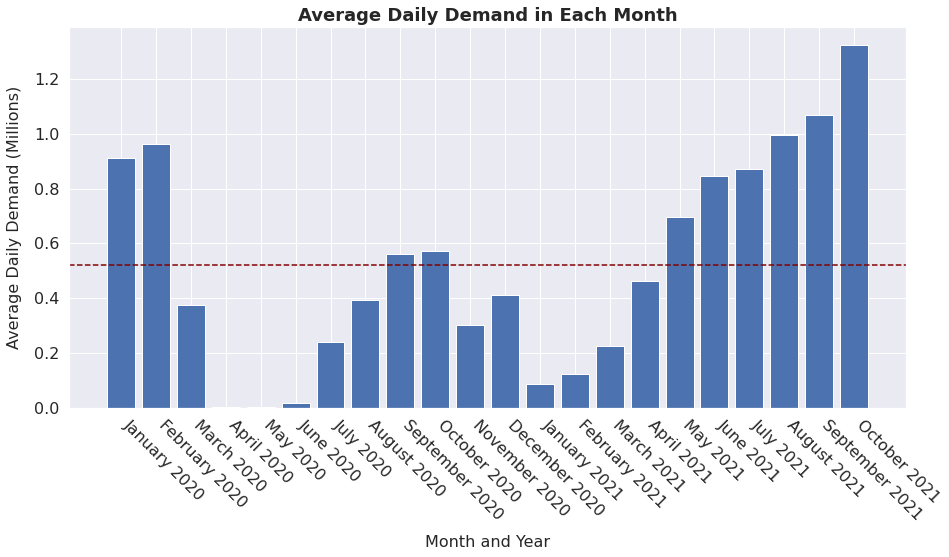

In [10]:
nums = pd.DataFrame(zip(ave_demand, n_entry_stn, n_exit_stn),
                    index=data_period_labels,
                    columns=['average_daily_demand','n_entrystations', 'n_exitstations'])

# Plot daily number of journeys
fig, ax = plt.subplots(figsize = (15,7))
ax.bar(nums.index, nums['average_daily_demand']/1000000)
ax.axhline(y=np.mean(nums['average_daily_demand']/1000000),
           linestyle='--',
           color='maroon')

plt.title('Average Daily Demand in Each Month',
          fontsize=18, weight='bold');
ax.set_xticklabels(data_period_labels)
ax.tick_params(labelsize=16)
plt.xticks(rotation=315, ha="left")
plt.xlabel('Month and Year', fontsize=16, labelpad=12);
plt.ylabel('Average Daily Demand (Millions)', fontsize=16, labelpad=12);

#fig.savefig('outputs/figures/demand_profile/ave_daily_journeys.png',
#            bbox_inches="tight")

nums.style.format({
    'average_daily_demand': '{:,.0f}'.format,
    'n_entrystations': '{:,.0f}'.format,
    'n_exitstations': '{:,.0f}'.format
})

From the table and the chart, we can clearly see the lower-than-normal journeys and stations for some months in the dataset. As such, I __restrict the months used in our analysis__. The following criteria are suggested:
- __At least 265 stations (out of 268 stations) for both entry and exit__
- __Average number of journeys per day above the average__

Based on these, the following months are retained:
- January 2020
- February 2020
- May 2021
- June 2021
- July 2021
- August 2021

Even though September and October 2020 also met these two criteria, I will not incude them because they were only slightly over the average.

In [11]:
# Dictionary of list for study period
study_period = {'2020': ['January', 'February'], 
               '2021': ['May', 'June', 'July', 'August']}

# List for data period
study_period_list = []
study_period_dict = {}
study_period_labels = []
for years, months in study_period.items():
    for month in months:
        study_period_list.append(month+years)
        study_period_labels.append(month + ' ' + years)
        study_period_dict[month+years] = month + ' ' + years

I will now check the difference in the number of stations from the 268 stations in the list.

In [12]:
entrystn_norecords = {}
exitstn_norecords = {}
list_lu_stn = set(df_stn['stn_name'])

# Check which are the stations without any records
for yr, mths in study_period.items():
    for mth in mths:
        mth_yr = mth+yr
        entrystn_norecords[mth_yr] = list(list_lu_stn-set(entry_stn[mth_yr]))
        exitstn_norecords[mth_yr] = list(list_lu_stn-set(exit_stn[mth_yr]))

In [13]:
entrystn_norecords

{'January2020': ['Battersea Power Station', 'Nine Elms'],
 'February2020': ['Battersea Power Station', 'Nine Elms'],
 'May2021': ['Heathrow Terminal 4 LU', 'Battersea Power Station', 'Nine Elms'],
 'June2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms'],
 'July2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms'],
 'August2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms']}

In [14]:
exitstn_norecords

{'January2020': ['Battersea Power Station', 'Nine Elms'],
 'February2020': ['Battersea Power Station', 'Nine Elms'],
 'May2021': ['Heathrow Terminal 4 LU', 'Battersea Power Station', 'Nine Elms'],
 'June2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms'],
 'July2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms'],
 'August2021': ['Heathrow Terminal 4 LU',
  'Battersea Power Station',
  'Nine Elms']}

The three stations that were not represented in the data set were:
- Battersea Power Station: opened only in September 2021
- Nine Elms: opened only in September 2021
- Heathrow Terminal 4 LU: terminal closed due to Covid-19

For consistency, I will drop Heathrow Terminal 4 LU from the study altogether; it is currently in the dataset for January - March 2020.

In [15]:
# Re-read df
del df_combined
df_combined = prep_data(study_period_list, df_stn, df_time)

READING: JANUARY2020
Cleaning stations
Cleaning date and time 

READING: FEBRUARY2020
Checking March2020
Cleaning stations
Cleaning date and time 

READING: MAY2021
Cleaning stations
Cleaning date and time 

READING: JUNE2021
Cleaning stations
Cleaning date and time 

READING: JULY2021
Cleaning stations
Cleaning date and time 

READING: AUGUST2021
Checking September2021
Cleaning stations
Cleaning date and time 

DONE!


In [16]:
# Drop Heathrow from the dataset
idx_heathrow = df_combined[(df_combined['EntryStationName'] ==
                            'Heathrow Terminal 4 LU') |
                           (df_combined['ExitStationName'] ==
                            'Heathrow Terminal 4 LU')].index
df_combined.drop(index=idx_heathrow, inplace=True)

## Typical profile for each day of the week

In [17]:
# Create mapper and dictionary to hold values
entrytime_start = df_time['timeslot']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_mapper = dict(zip(range(0, 7), days))

# Dictionary to hold value - {day: {time: [demand]}}
day_time_demand = {i: {j: [] for j in entrytime_start} for i in days}

# All timeslots in a day
full_time_set = set(entrytime_start)

In [18]:
# Check average demand per day, number of entry and exit stations in each month
for yr, mths in study_period.items():
    for mth in mths:

        # Segment data
        mth_yr = mth+yr
        print(f'Checking {mth_yr}')
        df_temp = df_combined[df_combined['OperatingDate_mthyr'] == mth_yr]

        # Get entries in each timeslots on each day in the month
        ts_entry = df_temp.groupby(['OperatingDate_dt',
                                    'EntryTimeslot'])['NumberOfJourneys']\
            .sum()\
            .reset_index()

        # Add in timeslots if there are no entries
        for curr_date in list(set(ts_entry['OperatingDate_dt'])):
            # Get set of timeslots on each day
            curr_timeslot =\
                set(ts_entry[ts_entry['OperatingDate_dt'] ==
                             curr_date]['EntryTimeslot'])
            # Get missing timeslots
            missing_timeslot = full_time_set - curr_timeslot
            n_missing = len(missing_timeslot)
            # Create and concat df of missing slots
            df_miss = pd.DataFrame(zip([curr_date] * n_missing,
                                       list(missing_timeslot),
                                       [0] * n_missing),
                                   columns=ts_entry.columns)
            ts_entry = pd.concat((ts_entry, df_miss))

        # Sort entries by date and time
        ts_entry = ts_entry\
            .sort_values(by=['OperatingDate_dt', 'EntryTimeslot'])\
            .reset_index(drop=True)

        # Repeat the process for exits
        ts_exit = df_temp.groupby(['OperatingDate_dt',
                                   'ExitTimeslot'])['NumberOfJourneys']\
            .sum()\
            .reset_index()
        ts_exit = ts_exit[ts_exit['ExitTimeslot'].isin(df_time['timeslot'])]

        # Add in timeslots if there are no exits
        for curr_date in list(set(ts_exit['OperatingDate_dt'])):
            # Get set of timeslots on each day
            curr_timeslot =\
                set(ts_exit[ts_exit['OperatingDate_dt'] ==
                            curr_date]['ExitTimeslot'])
            # Get missing timeslots
            missing_timeslot = full_time_set - curr_timeslot
            n_missing = len(missing_timeslot)
            # Create and concat df of missing slots
            df_miss = pd.DataFrame(zip([curr_date] * n_missing,
                                       list(missing_timeslot),
                                       [0] * n_missing),
                                   columns=ts_exit.columns)
            ts_exit = pd.concat((ts_exit, df_miss))

        # Sort exits by date and time
        ts_exit = ts_exit\
            .sort_values(by=['OperatingDate_dt', 'ExitTimeslot'])\
            .reset_index(drop=True)

        # Merge entries and exits to find demand
        ts_demand = ts_entry.merge(ts_exit,
                                   left_on=['OperatingDate_dt', 'EntryTimeslot'], 
                                   right_on=['OperatingDate_dt', 'ExitTimeslot'],
                                   suffixes=('_entries', '_exits'))
        ts_demand['tot_demand'] = ts_demand['NumberOfJourneys_entries']+\
            ts_demand['NumberOfJourneys_exits']
        # Get the day of the week
        ts_demand['OperatingDay'] = ts_demand['OperatingDate_dt'].dt.dayofweek
        ts_demand['Day'] = ts_demand['OperatingDay'].map(days_mapper)

        # Add the number of journeys to dictionary
        for k in range(len(ts_demand)):
            row = ts_demand.loc[k]
            day = row['Day']
            time = row['EntryTimeslot']
            day_time_demand[day][time].append(row['tot_demand'])

print('Done!')

Checking January2020
Checking February2020
Checking May2021
Checking June2021
Checking July2021
Checking August2021
Done!


In [19]:
# Create function to generate the demand profile for a given day
def demand_profile(time_demand):

    '''
    Convert data to typical demand profile for a day
    
    :param time_demand: dictionary of lists {timeslot: [number of journeys]}
    :return df_demand: dataframe of mean, SD, upper bound and lower bound for typical demand profile
    '''

    # Create lists to hold values for plotting typical demand profile
    # Mean, standard deviation, upper bound, lower bound
    demand_mean = []
    demand_std = []
    demand_ub = []
    demand_lb = []

    # Compute data for typical demand profile
    for demand_list in time_demand.values():
        demand_mean.append(np.mean(demand_list))
        demand_std.append(np.std(demand_list))
        demand_ub.append(np.percentile(demand_list, 97.5))
        demand_lb.append(np.percentile(demand_list, 2.5))

    # Create dataframe
    df_demand = pd.DataFrame(list(zip(time_demand.keys(), demand_mean,
                                      demand_std, demand_ub, demand_lb)), 
                             columns = ['Timeslot', 'Mean',
                                        'Std_Deviation', 'UB', 'LB'])
    
    return df_demand

In [20]:
# Set color palette and time mapper
col_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

time_map = {}
for i in range(len(df_time)):
    time_map[df_time.loc[i, 'timeslot']] = df_time.loc[i, 'entrytime_start']

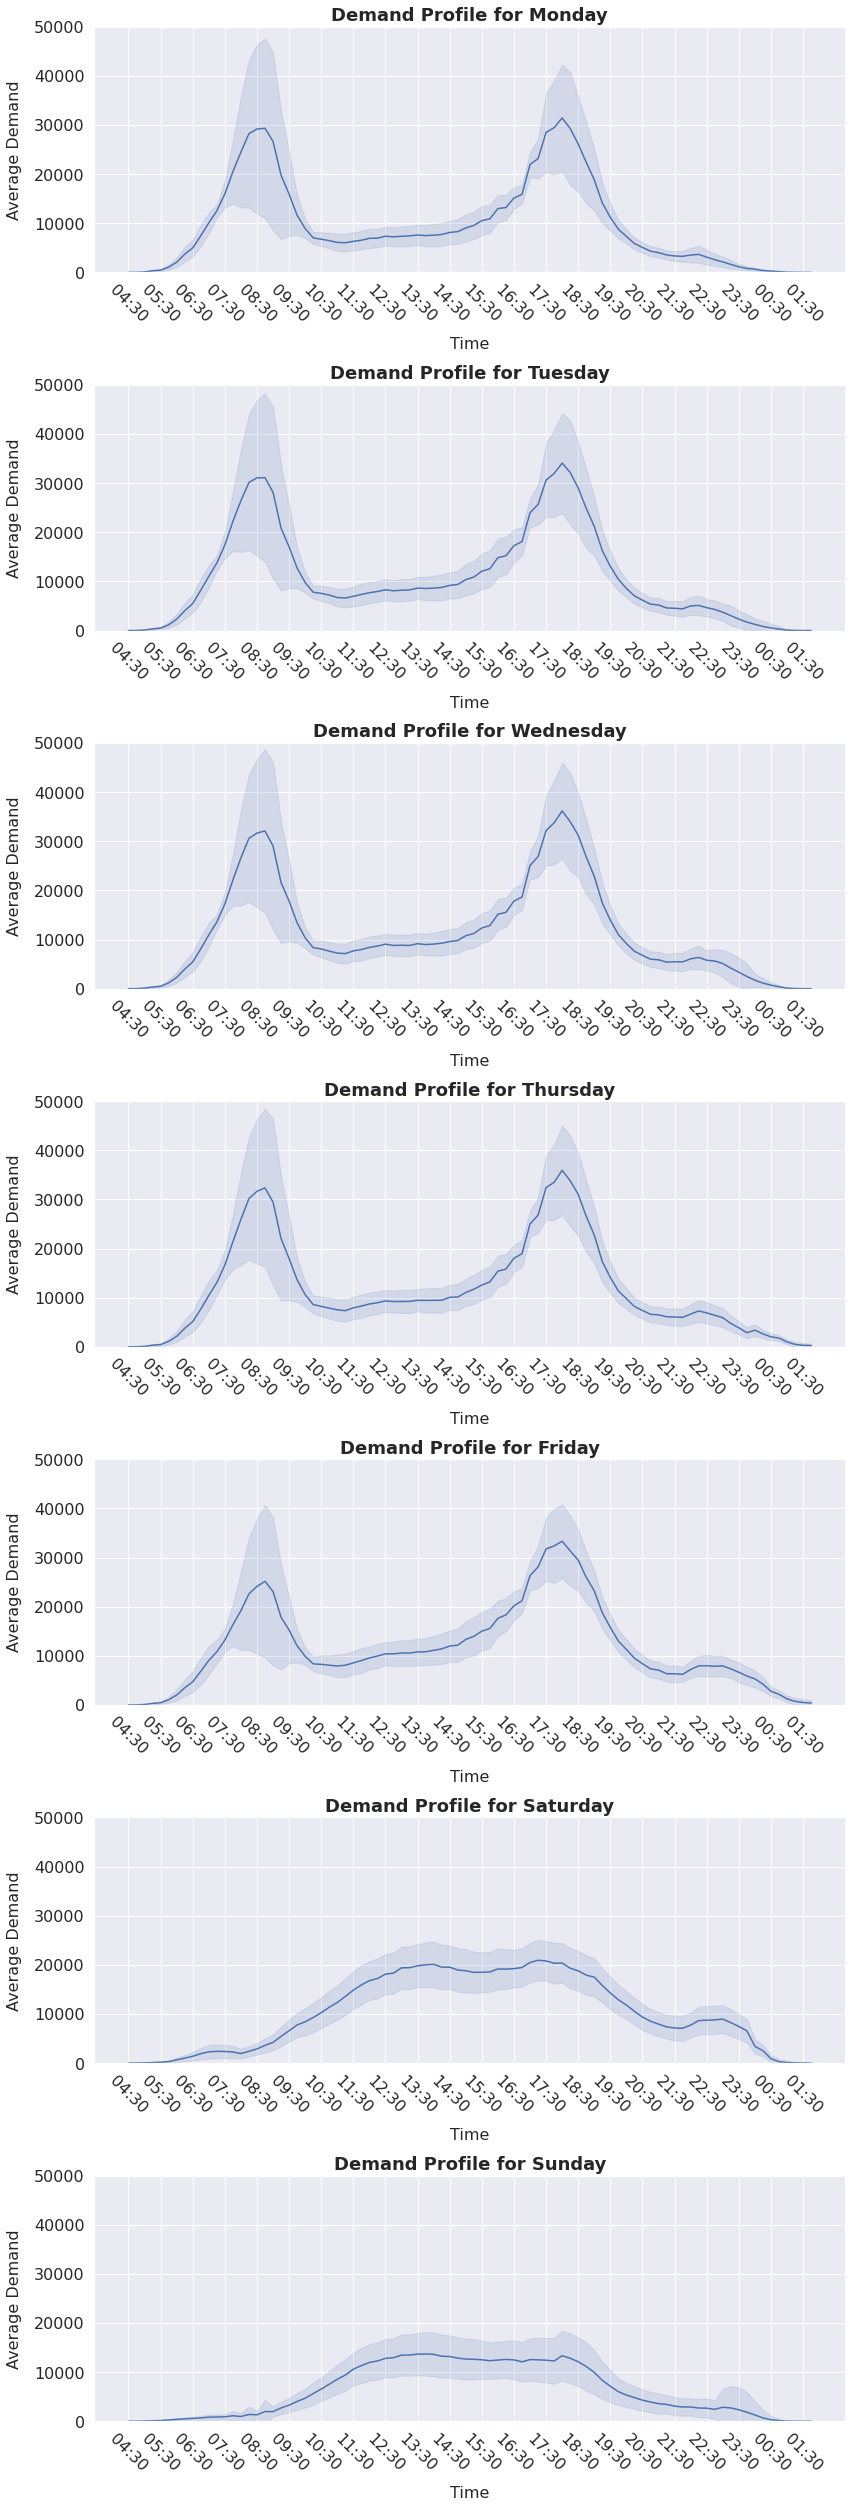

In [21]:
# Ignore runtime warning
warnings.simplefilter("ignore")

# Plot demand profile
fig, ax = plt.subplots(7, 1, figsize=(12, 35))

for i in range(len(days)):
    
    day = days[i]
    
    # Get demand profile
    df_plot = demand_profile(day_time_demand[day])
    df_plot['Timeslot'] = df_plot['Timeslot'].map(time_map)
    
    # Plot
    ax[i].plot(df_plot['Timeslot'], df_plot['Mean'])
    ax[i].fill_between(x=df_plot['Timeslot'], 
                       y1=df_plot['Mean']-df_plot['Std_Deviation'],
                       y2=df_plot['Mean']+df_plot['Std_Deviation'],
                       color=col_pal[0], alpha=0.15)
    
    ax[i].set_title(f"Demand Profile for {day}", fontsize=18, weight='bold')
    ax[i].tick_params(axis='x', rotation=315)
    ax[i].tick_params(labelsize=16)
    ax[i].set_xticks(range(0, 87, 4))
    ax[i].set_xlabel('Time', fontsize=16, labelpad=12)
    ax[i].set_ylim([0, 50000])
    ax[i].set_ylabel('Average Demand', fontsize=16, labelpad=12)
    
fig.tight_layout()

#fig.savefig('outputs/figures/demand_profile/daily_demand_profile.png',
#            bbox_inches="tight")

# Reset warnings
warnings.resetwarnings()

We can see that for Saturday and Sunday, the journeys are evenly distributed throughout the day and peak is generally lower. This contrasts with weekdays, when there are two distinct peaks in the morning and evening, and with higher peak values. Hence, I will restrict our project to focus on weekdays.

# Demand Data for Stations

I will now generate the time series data on the throughput, entry and exit for all stations individually.

In [22]:
# Re-load dataframe
del df_combined

# Remove the three stations omitted in this study
stn_omit = ['Battersea Power Station', 'Heathrow Terminal 4 LU', 'Nine Elms']
df_stn = df_stn[~df_stn['stn_name'].isin(stn_omit)]

df_combined = prep_data(study_period_list, df_stn, df_time)

READING: JANUARY2020
Cleaning stations
Cleaning date and time 

READING: FEBRUARY2020
Checking March2020
Cleaning stations
Cleaning date and time 

READING: MAY2021
Cleaning stations
Cleaning date and time 

READING: JUNE2021
Cleaning stations
Cleaning date and time 

READING: JULY2021
Cleaning stations
Cleaning date and time 

READING: AUGUST2021
Checking September2021
Cleaning stations
Cleaning date and time 

DONE!


In [23]:
# Choose whether to keep weekdays or weekends
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

df_sub = df_combined[df_combined['OperatingDay'].isin(weekdays)]

## Create functions for scalability

In [24]:
# Create function to generate time series data for individual stations
def stn_time_series(df, entex, stn_name, slots):
    
    '''
    Generate time series data where rows are the stations,
    columns are the timeslot, and values are the average number
    of journeys

    :param df: dataframe of data on number of journeys
    :param entex: choice of entry or exit; ['Entry', 'Exit']
    :param stn_name: list of station names
    :param slots: list of timeslots
    :return ts: time series dataframe
    '''

    df_func = df.copy()
    
    # Set up entry or exit
    stn_col = entex + 'StationName'
    slot_col = entex + 'Timeslot'
    
    # If exit, remove timeslots outside operating hours
    if entex == 'Exit':
        slots_list = [int(slot[5:]) for slot in slots]
        df_func = df_func[df_func[slot_col].isin(slots_list)]
    
    # Aggregate dataframe by entry station names, operating date, and timeslot,
    # then sum all the journeys
    ts_agg = df_func.groupby([stn_col, 'OperatingDate_dt', slot_col])\
        .agg({'NumberOfJourneys': 'sum'}).reset_index()

    # Get number of operating dates
    n_op_dates = len(set(ts_agg['OperatingDate_dt']))

    # Pivot table to find average number of journeys for each station (row)
    # in each timeslot
    ts = ts_agg.pivot_table(index=stn_col, columns=slot_col,
                            values='NumberOfJourneys', aggfunc='sum')
    ts = ts / n_op_dates
    ts.columns = ['slot_'+str(i) for i in ts.columns]
    ts.fillna(0, inplace=True)
    
    # Drop non-LU stations
    ts.drop(index='Non-LU', inplace=True)

    # If there are missing stations
    if ts.shape[0] != len(stn_name):
        # Find missing station
        missing_stn = list(set(stn_name) - set(ts.index))
        # Append rows of zeros
        ts = ts.append(pd.DataFrame(0, index=missing_stn, columns = ts.columns))

    # If there are missing time slots
    if ts.shape[1] != len(slots):
        # Find missing timeslots
        missing_slots = sorted(list(set(slots) - set(ts.columns)))
        # Insert columns of zeros in position
        for j in missing_slots:
            # Find position of columns to insert
            loc = int(j.split('_')[1])-1
            ts.insert(loc, j, [0]*ts.shape[0])

    return ts

In [25]:
# List of unique station names
stn_name = sorted(list(set(df_stn['stn_name'])))

# Labels of slots
slots = ['slot_'+str(i) for i in df_time['timeslot']]

In [26]:
# Generate time series dataframe of average counts for stations
stn_ts_entry = stn_time_series(df_sub, 'Entry', stn_name, slots)
stn_ts_exit = stn_time_series(df_sub, 'Exit', stn_name, slots)

# Sum entries and exits
stn_ts_throughput = stn_ts_entry.copy() + stn_ts_exit.copy()
stn_ts_throughput.index.name = 'StationName'

In [27]:
# Generate aggregrate profile
agg_ts_entry = pd.DataFrame(stn_ts_entry.sum(),
                            columns=['NumberOfJourneys'])
agg_ts_entry = agg_ts_entry.reset_index().\
        rename({'index': 'Timeslot'}, axis=1)

agg_ts_exit = pd.DataFrame(stn_ts_exit.sum(),
                           columns=['NumberOfJourneys'])
agg_ts_exit = agg_ts_exit.reset_index().\
    rename({'index': 'Timeslot'}, axis=1)

agg_ts_throughput = pd.DataFrame(stn_ts_throughput.sum(),
                                 columns=['NumberOfJourneys'])
agg_ts_throughput = agg_ts_throughput.reset_index().\
    rename({'index': 'Timeslot'}, axis=1)

In [28]:
# Save files
#stn_ts_entry.to_csv('outputs/stn_data/demand/stn_ts_entry.csv')
#stn_ts_exit.to_csv('outputs/stn_data/demand/stn_ts_exit.csv')
#stn_ts_throughput.to_csv('outputs/stn_data/demand/stn_ts_throughput.csv')

#agg_ts_entry.to_csv('outputs/stn_data/demand/agg_ts_entry.csv', index = False)
#agg_ts_exit.to_csv('outputs/stn_data/demand/agg_ts_exit.csv', index = False)
#agg_ts_throughput.to_csv('outputs/stn_data/demand/agg_ts_throughput.csv', index = False)